In [1]:
from phi.flow import *
from phi import __version__
print("Using phiflow version: {} ".format(phi.__version__))

import matplotlib.pyplot as plt

/Users/xushitong/miniconda3/envs/phyenv/lib/python3.11/site-packages/phi/math/backend/_dtype.py:135: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  DType(object): np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [2]:
N = 128
DX = 2./N
STEPS = 32
DT = 1./STEPS
NU = 0.01/(N*np.pi)
# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [4]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1])
vt = advect.semi_lagrangian(velocity, velocity, DT)
print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: " + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.4928982  0.53499764 0.57580817 0.6152316  0.65317285]


In [5]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
  v1 = diffuse.explicit(velocities[-1], NU, DT)
  v2 = advect.semi_lagrangian(v1, v1, DT)
  age += DT
  velocities.append(v2)
print("New velocity content at t={} : {} ".format( age, velocities[-1].values.numpy('x,vector ')[0:5] ))

New velocity content at t=1.0 : [[0.0057228 ]
 [0.01716715]
 [0.02861034]
 [0.04005201]
 [0.05149214]] 


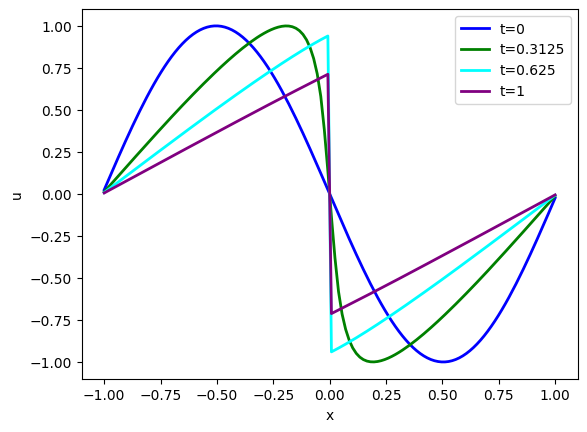

In [6]:
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays
import pylab
fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()